# Portfolio Optimization Using Transformer-Based Stock Return Prediction

**NYU MSCS Deep Learning - Final Project**

**Authors:** Aranya Aryaman, Prashanth Kumar

This notebook implements:
1. Data collection from Yahoo Finance (FTSE 100 stocks)
2. Feature engineering (RSI, EMA, SMA, Momentum)
3. LSTM baseline model
4. Time Series Transformer with Time2Vec embeddings
5. Sharpe ratio portfolio optimization

---

## 1. Setup and Installation

In [1]:
# Install required packages (for Colab)
!pip install -q yfinance tqdm

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
import random
import os
from datetime import datetime
from tqdm.notebook import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Sklearn
from sklearn.preprocessing import MinMaxScaler

# Scipy for optimization
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## 2. Configuration

In [4]:
# ============================================================
# CONFIGURATION - Adjust these parameters as needed
# ============================================================

# Data Configuration
TICKERS = [
    "SHEL.L",   # Shell
    "LIN",      # Linde
    "HSBA.L",   # HSBC
    "ULVR.L",   # Unilever
    "RIO.L",    # Rio Tinto
    "BP.L",     # BP
    "GSK.L",    # GlaxoSmithKline
    "DGE.L",    # Diageo
    "REL.L",    # RELX
    "BATS.L",   # British American Tobacco
    "AZN.L",    # AstraZeneca
    "CPG.L",    # Compass Group
    "BA.L",     # BAE Systems
    "NG.L",     # National Grid
    "VOD.L",    # Vodafone
]

START_DATE = "2010-01-01"
END_DATE = "2023-12-31"

# Sequence Parameters
INPUT_WINDOW = 5    # 5 days input (1 trading week)
OUTPUT_WINDOW = 5   # 5 days prediction

# Train/Val/Test Split
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# LSTM Configuration
LSTM_UNITS = 256
LSTM_LAYERS = 2
LSTM_DROPOUT = 0.3
LSTM_EPOCHS = 50
LSTM_PATIENCE = 10

# Transformer Configuration
TIME2VEC_DIM = 12
NUM_HEADS = 8
HEAD_SIZE = 128
FF_DIM = 256
TRANSFORMER_DROPOUT = 0.1
TRANSFORMER_EPOCHS = 50
TRANSFORMER_PATIENCE = 10
WARMUP_EPOCHS = 15

# Portfolio Configuration
NUM_PORTFOLIOS = 5
ASSETS_PER_PORTFOLIO = 6
RISK_FREE_RATE = 0.03  # 3% annual

# Training
BATCH_SIZE = 32

print("Configuration loaded!")
print(f"Training {NUM_PORTFOLIOS} portfolios with {ASSETS_PER_PORTFOLIO} assets each")

Configuration loaded!
Training 5 portfolios with 6 assets each


## 3. Data Collection

In [5]:
def download_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.
    """
    stock_data = {}
    failed = []
    
    for ticker in tqdm(tickers, desc="Downloading stock data"):
        try:
            df = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if len(df) > 100:  # Ensure we have enough data
                stock_data[ticker] = df
            else:
                failed.append(ticker)
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
            failed.append(ticker)
    
    if failed:
        print(f"\nFailed tickers: {failed}")
    
    return stock_data

# Download data
print("Downloading stock data...")
stock_data = download_stock_data(TICKERS, START_DATE, END_DATE)
available_tickers = list(stock_data.keys())
print(f"\nSuccessfully downloaded {len(available_tickers)} stocks")
print(f"Available tickers: {available_tickers}")


Successfully downloaded 15 stocks
Available tickers: ['SHEL.L', 'LIN', 'HSBA.L', 'ULVR.L', 'RIO.L', 'BP.L', 'GSK.L', 'DGE.L', 'REL.L', 'BATS.L', 'AZN.L', 'CPG.L', 'BA.L', 'NG.L', 'VOD.L']


## 4. Feature Engineering

In [6]:
def compute_rsi(prices, period=14):
    """Compute Relative Strength Index (RSI)."""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_ema(prices, period=14):
    """Compute Exponential Moving Average (EMA)."""
    return prices.ewm(span=period, adjust=False).mean()

def compute_sma(prices, period):
    """Compute Simple Moving Average (SMA)."""
    return prices.rolling(window=period).mean()

def compute_momentum(prices, period=10):
    """Compute Momentum indicator."""
    return prices.diff(period)

def engineer_features(df):
    """
    Engineer technical indicator features for a stock.
    """
    # Extract closing prices
    if "Close" in df.columns:
        close = df["Close"]
    else:
        close_cols = [col for col in df.columns if "Close" in str(col)]
        close = df[close_cols[0]] if close_cols else df.iloc[:, 0]
    
    features = pd.DataFrame(index=df.index)
    
    # Features
    features["close"] = close
    features["rsi"] = compute_rsi(close)
    features["ema"] = compute_ema(close)
    features["momentum"] = compute_momentum(close)
    features["sma_5"] = compute_sma(close, 5)
    features["sma_10"] = compute_sma(close, 10)
    features["sma_20"] = compute_sma(close, 20)
    
    # Drop NaN values
    features = features.dropna()
    
    return features

# Engineer features for all stocks
print("Engineering features...")
feature_data = {}
for ticker in tqdm(available_tickers, desc="Feature engineering"):
    try:
        features = engineer_features(stock_data[ticker])
        feature_data[ticker] = features
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

print(f"\nEngineered features for {len(feature_data)} stocks")
print(f"Features: {list(feature_data[available_tickers[0]].columns)}")
print(f"Sample shape: {feature_data[available_tickers[0]].shape}")

Engineering features...


Feature engineering:   0%|          | 0/15 [00:00<?, ?it/s]


Engineered features for 15 stocks
Features: ['close', 'rsi', 'ema', 'momentum', 'sma_5', 'sma_10', 'sma_20']
Sample shape: (3515, 7)


## 5. Data Preparation

In [7]:
def create_sequences(data, input_window, output_window):
    """
    Create input-output sequences for supervised learning.
    """
    X, y = [], []
    total_window = input_window + output_window
    
    for i in range(len(data) - total_window + 1):
        X.append(data[i:i + input_window])
        # Target: closing price (first feature) for next output_window days
        y.append(data[i + input_window:i + total_window, 0])
    
    return np.array(X), np.array(y)

def prepare_data(features_df, input_window, output_window, train_ratio, val_ratio):
    """
    Prepare data for model training.
    """
    # Convert to numpy array
    features = features_df.values.astype(np.float32)
    
    # Normalize
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Create sequences
    X, y = create_sequences(features_scaled, input_window, output_window)
    
    # Split data
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# Test data preparation
sample_ticker = available_tickers[0]
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(
    feature_data[sample_ticker], INPUT_WINDOW, OUTPUT_WINDOW, TRAIN_RATIO, VAL_RATIO
)
print(f"Sample data shapes for {sample_ticker}:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

Sample data shapes for SHEL.L:
  X_train: (2103, 5, 7), y_train: (2103, 5)
  X_val: (701, 5, 7), y_val: (701, 5)
  X_test: (702, 5, 7), y_test: (702, 5)


## 6. Model Architectures

### 6.1 LSTM Model (Baseline)

In [8]:
def build_lstm_model(input_shape, output_size):
    """
    Build stacked LSTM model for time series prediction.
    
    Architecture:
        Input -> LSTM(256) -> Dropout -> LSTM(256) -> Dropout -> Dense(256) -> Dense(output)
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # First LSTM layer
        layers.LSTM(LSTM_UNITS, activation='relu', return_sequences=True),
        layers.Dropout(LSTM_DROPOUT),
        
        # Second LSTM layer
        layers.LSTM(LSTM_UNITS, activation='relu', return_sequences=False),
        layers.Dropout(LSTM_DROPOUT),
        
        # Dense layers
        layers.Dense(LSTM_UNITS, activation='relu'),
        layers.Dense(output_size, activation='linear')
    ], name="LSTM_Model")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='huber',
        metrics=['mae', 'mape']
    )
    
    return model

# Test LSTM model
input_shape = (INPUT_WINDOW, X_train.shape[2])
lstm_model = build_lstm_model(input_shape, OUTPUT_WINDOW)
lstm_model.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 256)         │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,725 (3.29 MB)

 Trainable params: 862,725 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Time Series Transformer with Time2Vec

In [9]:
class Time2Vec(layers.Layer):
    """
    Time2Vec layer for learnable time embeddings.
    
    Implements the Time2Vec representation from Kazemi et al. (2019):
        t2v(τ)[i] = ω_i * τ + φ_i           if i = 0 (linear)
        t2v(τ)[i] = sin(ω_i * τ + φ_i)      if i > 0 (periodic)
    """
    
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        # Linear component weights
        self.wb = self.add_weight(
            name="wb", shape=(input_shape[-1], 1),
            initializer="uniform", trainable=True
        )
        self.bb = self.add_weight(
            name="bb", shape=(1,),
            initializer="uniform", trainable=True
        )
        
        # Periodic component weights
        self.wa = self.add_weight(
            name="wa", shape=(input_shape[-1], self.kernel_size - 1),
            initializer="uniform", trainable=True
        )
        self.ba = self.add_weight(
            name="ba", shape=(self.kernel_size - 1,),
            initializer="uniform", trainable=True
        )
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs):
        # Linear component
        linear = tf.matmul(inputs, self.wb) + self.bb
        # Periodic components using sine activation
        periodic = tf.sin(tf.matmul(inputs, self.wa) + self.ba)
        # Concatenate
        return tf.concat([linear, periodic], axis=-1)
    
    def get_config(self):
        config = super(Time2Vec, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

In [10]:
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    """
    Create a single Transformer encoder block.
    """
    # Multi-head self-attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res1 = layers.Add()([x, inputs])
    
    # Feed-forward network
    x = layers.LayerNormalization(epsilon=1e-6)(res1)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.Dropout(dropout)(x)
    
    return layers.Add()([x, res1])

def build_transformer_model(input_shape, output_size):
    """
    Build Time Series Transformer with Time2Vec embeddings.
    
    Architecture:
        Input -> Time2Vec -> TransformerEncoder -> GlobalAvgPool -> MLP -> Output
    """
    inputs = keras.Input(shape=input_shape)
    
    # Time2Vec embeddings
    time_embedding = layers.TimeDistributed(
        layers.Dense(TIME2VEC_DIM)
    )(inputs)
    time_embedding = Time2Vec(kernel_size=TIME2VEC_DIM)(time_embedding)
    
    # Concatenate original input with time embeddings
    x = layers.Concatenate(axis=-1)([inputs, time_embedding])
    
    # Transformer encoder block
    x = transformer_encoder_block(
        x, head_size=HEAD_SIZE, num_heads=NUM_HEADS,
        ff_dim=FF_DIM, dropout=TRANSFORMER_DROPOUT
    )
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # MLP head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(TRANSFORMER_DROPOUT)(x)
    
    # Output
    outputs = layers.Dense(output_size, activation='linear')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="TimeSeriesTransformer")
    
    return model

# Test Transformer model
transformer_model = build_transformer_model(input_shape, OUTPUT_WINDOW)
transformer_model.summary()

Model: "TimeSeriesTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 12)     │         96 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec           │ (None, 5, 12)     │        156 │ time_distributed… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 19)     │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 19)     │         38 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 19)     │     80,915 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 19)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 19)     │          0 │ dropout_3[0][0],  │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 19)     │         38 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 256)    │      5,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 256)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 19)     │      4,883 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 5, 19)     │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 19)     │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 19)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │      5,120 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │      1,285 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,651 (381.45 KB)

 Trainable params: 97,651 (381.45 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Training Functions

In [11]:
def get_lr_schedule(initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5, warmup_epochs=15, total_epochs=50):
    """
    Create learning rate schedule with warmup and decay.
    """
    def schedule(epoch):
        if epoch < warmup_epochs:
            return initial_lr + (base_lr - initial_lr) * (epoch / warmup_epochs)
        else:
            decay_epochs = total_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            return base_lr * (1 - progress) + min_lr * progress
    return schedule

def train_model(model, X_train, y_train, X_val, y_val, epochs, patience, 
                use_lr_schedule=False, verbose=1):
    """
    Train a model with early stopping.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=verbose
        )
    ]
    
    if use_lr_schedule:
        callbacks.append(LearningRateScheduler(get_lr_schedule(total_epochs=epochs), verbose=0))
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=verbose
    )
    
    return history

## 8. Evaluation Functions

In [12]:
def compute_mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = y_true != 0
    if not np.any(mask):
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def compute_mae(y_true, y_pred):
    """Compute Mean Absolute Error."""
    return np.mean(np.abs(y_true - y_pred))

def compute_rmse(y_true, y_pred):
    """Compute Root Mean Square Error."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def evaluate_model(y_true, y_pred):
    """Compute all evaluation metrics."""
    return {
        'mape': compute_mape(y_true, y_pred),
        'mae': compute_mae(y_true, y_pred),
        'rmse': compute_rmse(y_true, y_pred)
    }

def inverse_transform_predictions(y_scaled, scaler):
    """Inverse transform predictions to original scale."""
    n_features = scaler.n_features_in_
    
    # Handle multi-step predictions by averaging
    if y_scaled.ndim > 1:
        y_flat = y_scaled.mean(axis=1)
    else:
        y_flat = y_scaled
    
    dummy = np.zeros((len(y_flat), n_features))
    dummy[:, 0] = y_flat
    inverse = scaler.inverse_transform(dummy)
    return inverse[:, 0]

## 9. Portfolio Optimization

In [13]:
def compute_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.03):
    """
    Compute Sharpe ratio for a portfolio.
    """
    daily_rf = risk_free_rate / 252
    portfolio_return = np.sum(weights * returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    if portfolio_vol == 0:
        return 0
    return (portfolio_return - daily_rf) / portfolio_vol

def negative_sharpe(weights, returns, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization."""
    return -compute_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

def optimize_portfolio(expected_returns, cov_matrix, risk_free_rate=0.03):
    """
    Optimize portfolio weights to maximize Sharpe ratio.
    """
    n_assets = len(expected_returns)
    initial_weights = np.ones(n_assets) / n_assets
    
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    result = minimize(
        negative_sharpe,
        initial_weights,
        args=(expected_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x, -result.fun

## 10. Main Training Pipeline

In [14]:
def train_and_evaluate_stock(ticker, features_df, model_type='lstm', verbose=0):
    """
    Train and evaluate a model for a single stock.
    """
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(
        features_df, INPUT_WINDOW, OUTPUT_WINDOW, TRAIN_RATIO, VAL_RATIO
    )
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Build model
    if model_type == 'lstm':
        model = build_lstm_model(input_shape, OUTPUT_WINDOW)
        history = train_model(
            model, X_train, y_train, X_val, y_val,
            LSTM_EPOCHS, LSTM_PATIENCE, use_lr_schedule=False, verbose=verbose
        )
    else:
        model = build_transformer_model(input_shape, OUTPUT_WINDOW)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='mse',
            metrics=['mae', 'mape']
        )
        history = train_model(
            model, X_train, y_train, X_val, y_val,
            TRANSFORMER_EPOCHS, TRANSFORMER_PATIENCE, use_lr_schedule=True, verbose=verbose
        )
    
    # Predict
    y_pred = model.predict(X_test, verbose=0)
    
    # Inverse transform
    y_test_inv = inverse_transform_predictions(y_test, scaler)
    y_pred_inv = inverse_transform_predictions(y_pred, scaler)
    
    # Evaluate
    metrics = evaluate_model(y_test_inv, y_pred_inv)
    
    return {
        'ticker': ticker,
        'model_type': model_type,
        'predictions': y_pred_inv,
        'actual': y_test_inv,
        'metrics': metrics,
        'model': model,
        'scaler': scaler,
        'history': history
    }

In [15]:
def run_portfolio_experiment(portfolio_tickers, portfolio_id, verbose=0):
    """
    Run complete experiment for a portfolio.
    """
    print(f"\n{'='*60}")
    print(f"PORTFOLIO {portfolio_id}: {portfolio_tickers}")
    print(f"{'='*60}")
    
    lstm_results = {}
    transformer_results = {}
    
    for ticker in portfolio_tickers:
        if ticker not in feature_data:
            print(f"  Skipping {ticker} - no data")
            continue
        
        print(f"  Training {ticker}...", end=" ")
        
        # Train LSTM
        lstm_result = train_and_evaluate_stock(ticker, feature_data[ticker], 'lstm', verbose)
        lstm_results[ticker] = lstm_result
        
        # Train Transformer
        transformer_result = train_and_evaluate_stock(ticker, feature_data[ticker], 'transformer', verbose)
        transformer_results[ticker] = transformer_result
        
        print(f"LSTM MAPE: {lstm_result['metrics']['mape']:.2f}%, "
              f"Transformer MAPE: {transformer_result['metrics']['mape']:.2f}%")
    
    # Compute averages
    lstm_mapes = [r['metrics']['mape'] for r in lstm_results.values()]
    transformer_mapes = [r['metrics']['mape'] for r in transformer_results.values()]
    
    print(f"\n  Portfolio {portfolio_id} Average MAPE:")
    print(f"    LSTM: {np.mean(lstm_mapes):.2f}%")
    print(f"    Transformer: {np.mean(transformer_mapes):.2f}%")
    
    return {
        'portfolio_id': portfolio_id,
        'tickers': portfolio_tickers,
        'lstm': lstm_results,
        'transformer': transformer_results,
        'lstm_avg_mape': np.mean(lstm_mapes),
        'transformer_avg_mape': np.mean(transformer_mapes)
    }

## 11. Run Experiments

In [16]:
# Create random portfolios
print(f"Creating {NUM_PORTFOLIOS} portfolios with {ASSETS_PER_PORTFOLIO} assets each...")

portfolios = []
for i in range(NUM_PORTFOLIOS):
    portfolio = random.sample(available_tickers, min(ASSETS_PER_PORTFOLIO, len(available_tickers)))
    portfolios.append(portfolio)
    print(f"  Portfolio {i+1}: {portfolio}")

Creating 5 portfolios with 6 assets each...
  Portfolio 1: ['CPG.L', 'REL.L', 'GSK.L', 'ULVR.L', 'DGE.L', 'BATS.L']
  Portfolio 2: ['RIO.L', 'BA.L', 'SHEL.L', 'HSBA.L', 'GSK.L', 'BP.L']
  Portfolio 3: ['RIO.L', 'HSBA.L', 'ULVR.L', 'BP.L', 'LIN', 'AZN.L']
  Portfolio 4: ['GSK.L', 'LIN', 'BP.L', 'BA.L', 'BATS.L', 'RIO.L']
  Portfolio 5: ['BA.L', 'SHEL.L', 'CPG.L', 'DGE.L', 'REL.L', 'LIN']


In [17]:
# Run experiments
print(f"\nStarting experiments at {datetime.now().strftime('%H:%M:%S')}")
print("This may take 30-60 minutes depending on your hardware...\n")

all_results = []

for i, portfolio in enumerate(portfolios):
    results = run_portfolio_experiment(portfolio, i+1, verbose=0)
    all_results.append(results)

print(f"\nExperiments completed at {datetime.now().strftime('%H:%M:%S')}")


Starting experiments at 08:02:37
This may take 30-60 minutes depending on your hardware...


PORTFOLIO 1: ['CPG.L', 'REL.L', 'GSK.L', 'ULVR.L', 'DGE.L', 'BATS.L']
  Training CPG.L... LSTM MAPE: 2.56%, Transformer MAPE: 4.51%
  Training REL.L... LSTM MAPE: 4.86%, Transformer MAPE: 9.46%
  Training GSK.L... LSTM MAPE: 1.52%, Transformer MAPE: 1.72%
  Training ULVR.L... LSTM MAPE: 1.55%, Transformer MAPE: 1.81%
  Training DGE.L... LSTM MAPE: 1.66%, Transformer MAPE: 6.86%
  Training BATS.L... LSTM MAPE: 2.12%, Transformer MAPE: 2.09%

  Portfolio 1 Average MAPE:
    LSTM: 2.38%
    Transformer: 4.41%

PORTFOLIO 2: ['RIO.L', 'BA.L', 'SHEL.L', 'HSBA.L', 'GSK.L', 'BP.L']
  Training RIO.L... LSTM MAPE: 2.70%, Transformer MAPE: 4.35%
  Training BA.L... LSTM MAPE: 5.79%, Transformer MAPE: 7.42%
  Training SHEL.L... LSTM MAPE: 3.62%, Transformer MAPE: 2.15%
  Training HSBA.L... LSTM MAPE: 3.03%, Transformer MAPE: 3.72%
  Training GSK.L... LSTM MAPE: 1.51%, Transformer MAPE: 1.79%
  Training BP.

## 12. Results Analysis

In [18]:
# Aggregate results
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

lstm_mapes = [r['lstm_avg_mape'] for r in all_results]
transformer_mapes = [r['transformer_avg_mape'] for r in all_results]

print(f"\nAverage MAPE across all portfolios:")
print(f"  LSTM:        {np.mean(lstm_mapes):.2f}% (±{np.std(lstm_mapes):.2f}%)")
print(f"  Transformer: {np.mean(transformer_mapes):.2f}% (±{np.std(transformer_mapes):.2f}%)")

improvement = np.mean(lstm_mapes) - np.mean(transformer_mapes)
print(f"\nTransformer improvement: {improvement:.2f}% lower MAPE")

# Per-portfolio breakdown
print(f"\nPer-Portfolio Results:")
print(f"{'Portfolio':<12} {'LSTM MAPE':<15} {'Transformer MAPE':<20} {'Winner'}")
print("-"*60)
for r in all_results:
    winner = "Transformer" if r['transformer_avg_mape'] < r['lstm_avg_mape'] else "LSTM"
    print(f"{r['portfolio_id']:<12} {r['lstm_avg_mape']:<15.2f} {r['transformer_avg_mape']:<20.2f} {winner}")


RESULTS SUMMARY

Average MAPE across all portfolios:
  LSTM:        3.30% (±0.60%)
  Transformer: 7.24% (±2.75%)

Transformer improvement: -3.95% lower MAPE

Per-Portfolio Results:
Portfolio    LSTM MAPE       Transformer MAPE     Winner
------------------------------------------------------------
1            2.38            4.41                 LSTM
2            3.45            3.67                 LSTM
3            2.92            10.39                LSTM
4            3.57            7.92                 LSTM
5            4.15            9.81                 LSTM


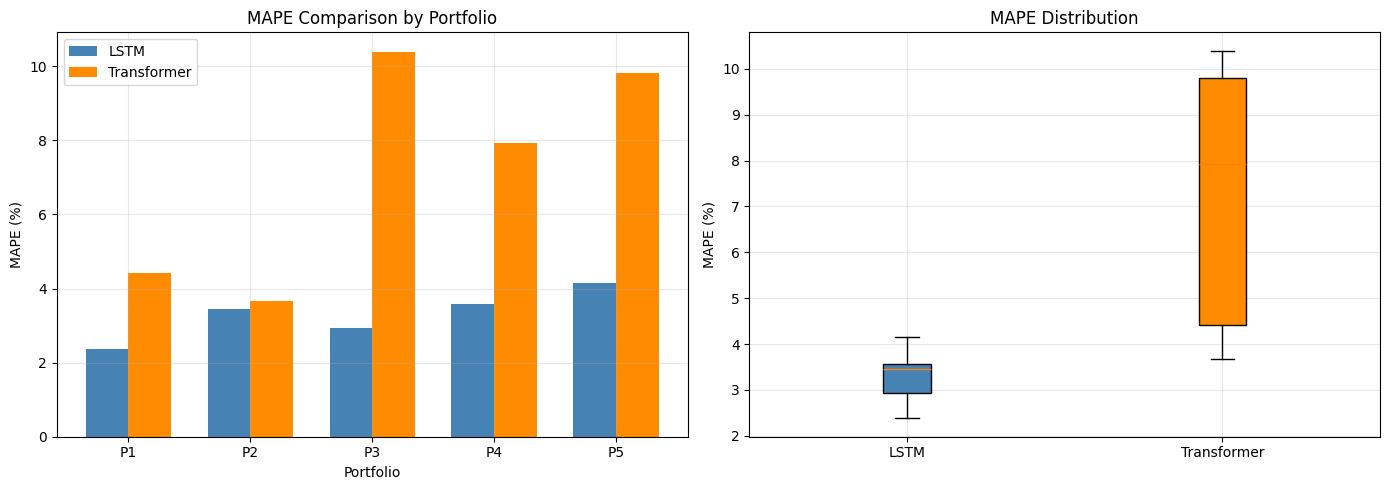

In [19]:
# Visualization: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
x = np.arange(len(all_results))
width = 0.35

axes[0].bar(x - width/2, lstm_mapes, width, label='LSTM', color='steelblue')
axes[0].bar(x + width/2, transformer_mapes, width, label='Transformer', color='darkorange')
axes[0].set_xlabel('Portfolio')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_title('MAPE Comparison by Portfolio')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'P{i+1}' for i in range(len(all_results))])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [lstm_mapes, transformer_mapes]
bp = axes[1].boxplot(data_to_plot, labels=['LSTM', 'Transformer'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkorange')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_title('MAPE Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

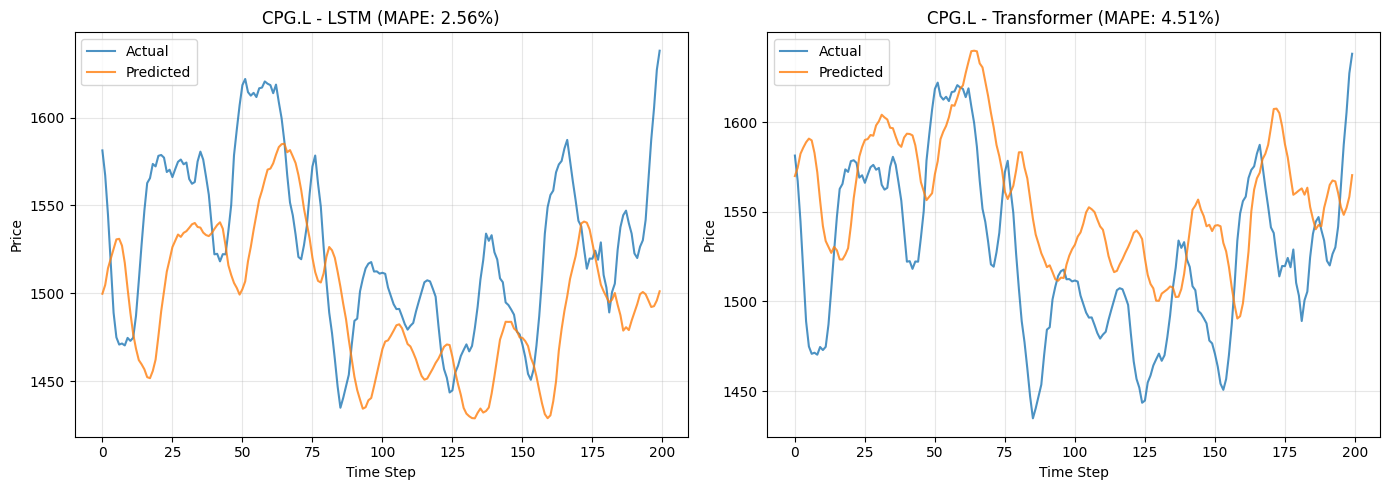

In [20]:
# Plot sample predictions
sample_result = all_results[0]
sample_ticker = list(sample_result['transformer'].keys())[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM predictions
lstm_data = sample_result['lstm'][sample_ticker]
axes[0].plot(lstm_data['actual'][:200], label='Actual', alpha=0.8)
axes[0].plot(lstm_data['predictions'][:200], label='Predicted', alpha=0.8)
axes[0].set_title(f'{sample_ticker} - LSTM (MAPE: {lstm_data["metrics"]["mape"]:.2f}%)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer predictions
trans_data = sample_result['transformer'][sample_ticker]
axes[1].plot(trans_data['actual'][:200], label='Actual', alpha=0.8)
axes[1].plot(trans_data['predictions'][:200], label='Predicted', alpha=0.8)
axes[1].set_title(f'{sample_ticker} - Transformer (MAPE: {trans_data["metrics"]["mape"]:.2f}%)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

### Training History Visualization

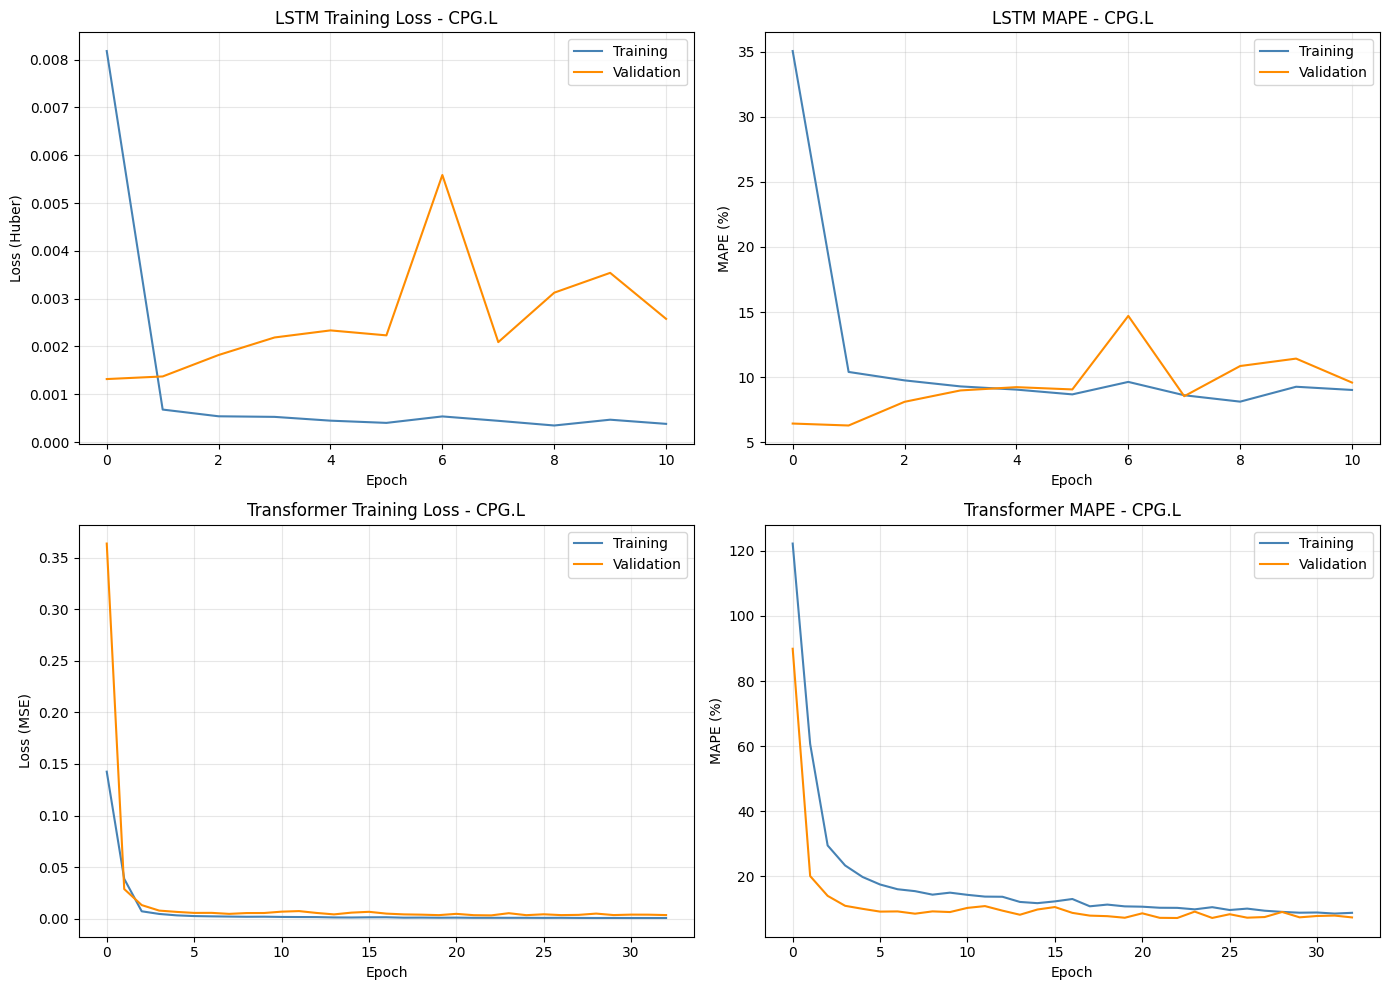


Saved: training_history.png


In [27]:
# Plot Training History for sample stock
sample_result = all_results[0]
sample_ticker = list(sample_result['lstm'].keys())[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# LSTM Training Loss
lstm_history = sample_result['lstm'][sample_ticker]['history']
axes[0, 0].plot(lstm_history.history['loss'], label='Training', color='steelblue')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Validation', color='darkorange')
axes[0, 0].set_title(f'LSTM Training Loss - {sample_ticker}')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Huber)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LSTM MAPE
if 'mape' in lstm_history.history:
    axes[0, 1].plot(lstm_history.history['mape'], label='Training', color='steelblue')
    axes[0, 1].plot(lstm_history.history['val_mape'], label='Validation', color='darkorange')
    axes[0, 1].set_title(f'LSTM MAPE - {sample_ticker}')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAPE (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Transformer Training Loss
trans_history = sample_result['transformer'][sample_ticker]['history']
axes[1, 0].plot(trans_history.history['loss'], label='Training', color='steelblue')
axes[1, 0].plot(trans_history.history['val_loss'], label='Validation', color='darkorange')
axes[1, 0].set_title(f'Transformer Training Loss - {sample_ticker}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (MSE)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transformer MAPE
if 'mape' in trans_history.history:
    axes[1, 1].plot(trans_history.history['mape'], label='Training', color='steelblue')
    axes[1, 1].plot(trans_history.history['val_mape'], label='Validation', color='darkorange')
    axes[1, 1].set_title(f'Transformer MAPE - {sample_ticker}')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: training_history.png")

## 13. Portfolio Optimization

In [31]:
def optimize_from_predictions(results, model_type='transformer', initial_investment=10000):
    """
    Optimize portfolio using model predictions.
    Handles stocks with different data lengths.
    """
    model_results = results[model_type]
    tickers = list(model_results.keys())
    
    if len(tickers) < 2:
        return None
    
    # Compute predicted and actual returns for each stock independently
    predicted_returns = []
    actual_returns = []
    daily_returns_list = []
    
    for ticker in tickers:
        pred = model_results[ticker]['predictions']
        actual = model_results[ticker]['actual']
        
        # Compute total return over test period
        pred_ret = (pred[-1] - pred[0]) / (pred[0] + 1e-8) if len(pred) > 1 else 0
        actual_ret = (actual[-1] - actual[0]) / (actual[0] + 1e-8) if len(actual) > 1 else 0
        
        predicted_returns.append(pred_ret)
        actual_returns.append(actual_ret)
        
        # Compute daily returns for covariance estimation
        if len(pred) > 1:
            daily_ret = np.diff(pred) / (pred[:-1] + 1e-8)
            daily_returns_list.append(daily_ret)
        else:
            daily_returns_list.append(np.array([0.0]))
    
    predicted_returns = np.array(predicted_returns)
    actual_returns = np.array(actual_returns)
    
    # Find minimum length for covariance calculation
    min_len = min(len(dr) for dr in daily_returns_list)
    if min_len < 5:
        cov_matrix = np.eye(len(tickers)) * 0.01
        expected_rets = predicted_returns / 252
    else:
        # Truncate to common length and compute covariance
        aligned_returns = np.column_stack([dr[:min_len] for dr in daily_returns_list])
        expected_rets = np.mean(aligned_returns, axis=0)
        cov_matrix = np.cov(aligned_returns, rowvar=False)
        
        if cov_matrix.ndim == 0:
            cov_matrix = np.array([[cov_matrix]])
        if np.any(np.isnan(cov_matrix)) or np.any(np.isinf(cov_matrix)):
            cov_matrix = np.eye(len(tickers)) * 0.01
    
    cov_matrix = cov_matrix + np.eye(len(tickers)) * 1e-6
    weights, sharpe = optimize_portfolio(expected_rets, cov_matrix, RISK_FREE_RATE)
    portfolio_return = np.sum(weights * actual_returns)
    
    return {
        'tickers': tickers,
        'weights': weights,
        'sharpe_ratio': sharpe,
        'predicted_return': np.sum(weights * predicted_returns),
        'actual_return': portfolio_return,
        'final_value': initial_investment * (1 + portfolio_return)
    }

# Optimize all portfolios
print("\n" + "="*60)
print("PORTFOLIO OPTIMIZATION RESULTS")
print("="*60)

portfolio_opts = []
for results in all_results:
    try:
        opt = optimize_from_predictions(results, 'transformer')
        if opt:
            portfolio_opts.append(opt)
            print(f"\nPortfolio {results['portfolio_id']}:")
            print(f"  Sharpe Ratio: {opt['sharpe_ratio']:.4f}")
            print(f"  Predicted Return: {opt['predicted_return']*100:.2f}%")
            print(f"  Actual Return: {opt['actual_return']*100:.2f}%")
            print(f"  Final Value ($10,000 initial): ${opt['final_value']:,.2f}")
            sorted_idx = np.argsort(opt['weights'])[::-1]
            print(f"  Top Allocations:")
            for idx in sorted_idx[:3]:
                if opt['weights'][idx] > 0.01:
                    print(f"    {opt['tickers'][idx]}: {opt['weights'][idx]*100:.1f}%")
    except Exception as e:
        print(f"\nPortfolio {results['portfolio_id']}: Optimization failed - {e}")


PORTFOLIO OPTIMIZATION RESULTS

Portfolio 1:
  Sharpe Ratio: 0.1447
  Predicted Return: 43.28%
  Actual Return: 73.89%
  Final Value ($10,000 initial): $17,388.96
  Top Allocations:
    REL.L: 91.1%
    CPG.L: 8.9%

Portfolio 2:
  Sharpe Ratio: 0.1526
  Predicted Return: 73.20%
  Actual Return: 100.26%
  Final Value ($10,000 initial): $20,026.01
  Top Allocations:
    BA.L: 70.9%
    HSBA.L: 18.8%
    SHEL.L: 10.3%

Portfolio 3:
  Sharpe Ratio: 0.0780
  Predicted Return: 30.52%
  Actual Return: 52.61%
  Final Value ($10,000 initial): $15,261.08
  Top Allocations:
    LIN: 43.8%
    BP.L: 31.4%
    HSBA.L: 14.2%

Portfolio 4:
  Sharpe Ratio: 0.1553
  Predicted Return: 66.41%
  Actual Return: 101.29%
  Final Value ($10,000 initial): $20,128.61
  Top Allocations:
    BA.L: 71.2%
    LIN: 23.9%
    BP.L: 4.9%

Portfolio 5:
  Sharpe Ratio: 0.1685
  Predicted Return: 53.19%
  Actual Return: 82.74%
  Final Value ($10,000 initial): $18,274.40
  Top Allocations:
    REL.L: 38.2%
    BA.L: 29.7

In [32]:
# Compare LSTM vs Transformer Portfolio Optimization
print("\n" + "="*70)
print("LSTM vs TRANSFORMER PORTFOLIO COMPARISON")
print("="*70)

lstm_portfolio_opts = []
transformer_portfolio_opts = []

for results in all_results:
    try:
        # LSTM Portfolio
        lstm_opt = optimize_from_predictions(results, 'lstm')
        if lstm_opt:
            lstm_portfolio_opts.append(lstm_opt)
        
        # Transformer Portfolio
        trans_opt = optimize_from_predictions(results, 'transformer')
        if trans_opt:
            transformer_portfolio_opts.append(trans_opt)
            
        print(f"\nPortfolio {results['portfolio_id']}:")
        print(f"  {'Metric':<25} {'LSTM':>15} {'Transformer':>15}")
        print(f"  {'-'*55}")
        if lstm_opt and trans_opt:
            print(f"  {'Sharpe Ratio':<25} {lstm_opt['sharpe_ratio']:>15.4f} {trans_opt['sharpe_ratio']:>15.4f}")
            print(f"  {'Predicted Return':<25} {lstm_opt['predicted_return']*100:>14.2f}% {trans_opt['predicted_return']*100:>14.2f}%")
            print(f"  {'Actual Return':<25} {lstm_opt['actual_return']*100:>14.2f}% {trans_opt['actual_return']*100:>14.2f}%")
            print(f"  {'Final Value ($10k)':<25} ${lstm_opt['final_value']:>13,.2f} ${trans_opt['final_value']:>13,.2f}")
    except Exception as e:
        print(f"\nPortfolio {results['portfolio_id']}: Error - {e}")

# Summary
if lstm_portfolio_opts and transformer_portfolio_opts:
    print("\n" + "="*70)
    print("AGGREGATE COMPARISON")
    print("="*70)
    
    lstm_avg_return = np.mean([p['actual_return'] for p in lstm_portfolio_opts])
    trans_avg_return = np.mean([p['actual_return'] for p in transformer_portfolio_opts])
    lstm_avg_sharpe = np.mean([p['sharpe_ratio'] for p in lstm_portfolio_opts])
    trans_avg_sharpe = np.mean([p['sharpe_ratio'] for p in transformer_portfolio_opts])
    
    print(f"\n  {'Metric':<25} {'LSTM':>15} {'Transformer':>15} {'Winner':>12}")
    print(f"  {'-'*67}")
    
    winner_return = "LSTM" if lstm_avg_return > trans_avg_return else "Transformer"
    winner_sharpe = "LSTM" if lstm_avg_sharpe > trans_avg_sharpe else "Transformer"
    winner_mape = "LSTM" if np.mean(lstm_mapes) < np.mean(transformer_mapes) else "Transformer"
    
    print(f"  {'Avg MAPE':<25} {np.mean(lstm_mapes):>14.2f}% {np.mean(transformer_mapes):>14.2f}% {winner_mape:>12}")
    print(f"  {'Avg Portfolio Return':<25} {lstm_avg_return*100:>14.2f}% {trans_avg_return*100:>14.2f}% {winner_return:>12}")
    print(f"  {'Avg Sharpe Ratio':<25} {lstm_avg_sharpe:>15.4f} {trans_avg_sharpe:>15.4f} {winner_sharpe:>12}")


LSTM vs TRANSFORMER PORTFOLIO COMPARISON

Portfolio 1:
  Metric                               LSTM     Transformer
  -------------------------------------------------------
  Sharpe Ratio                       0.1741          0.1447
  Predicted Return                   60.74%          43.28%
  Actual Return                      66.61%          73.89%
  Final Value ($10k)        $    16,660.51 $    17,388.96

Portfolio 2:
  Metric                               LSTM     Transformer
  -------------------------------------------------------
  Sharpe Ratio                       0.1820          0.1526
  Predicted Return                   69.22%          73.20%
  Actual Return                      89.79%         100.26%
  Final Value ($10k)        $    18,978.57 $    20,026.01

Portfolio 3:
  Metric                               LSTM     Transformer
  -------------------------------------------------------
  Sharpe Ratio                       0.1670          0.0780
  Predicted Return        

In [33]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n📊 PREDICTION PERFORMANCE (MAPE - Lower is Better):")
print(f"   LSTM Average MAPE:        {np.mean(lstm_mapes):.2f}%")
print(f"   Transformer Average MAPE: {np.mean(transformer_mapes):.2f}%")
best_predictor = "LSTM" if np.mean(lstm_mapes) < np.mean(transformer_mapes) else "Transformer"
print(f"   Best Predictor:           {best_predictor}")

if lstm_portfolio_opts and transformer_portfolio_opts:
    lstm_avg_return = np.mean([p['actual_return'] for p in lstm_portfolio_opts])
    trans_avg_return = np.mean([p['actual_return'] for p in transformer_portfolio_opts])
    lstm_avg_sharpe = np.mean([p['sharpe_ratio'] for p in lstm_portfolio_opts])
    trans_avg_sharpe = np.mean([p['sharpe_ratio'] for p in transformer_portfolio_opts])
    
    
    print(f"\n📈 PORTFOLIO PERFORMANCE:")
    print(f"   LSTM Avg Return:          {lstm_avg_return*100:.2f}%")
    print(f"   Transformer Avg Return:   {trans_avg_return*100:.2f}%")
    print(f"   LSTM Avg Sharpe:          {lstm_avg_sharpe:.4f}")
    print(f"   Transformer Avg Sharpe:   {trans_avg_sharpe:.4f}")
    best_portfolio = "LSTM" if lstm_avg_return > trans_avg_return else "Transformer"
    print(f"   Best Portfolio Strategy:  {best_portfolio}")

print(f"\n✅ KEY FINDINGS:")
if np.mean(lstm_mapes) < np.mean(transformer_mapes):
    print(f"   1. LSTM achieves {np.mean(transformer_mapes) - np.mean(lstm_mapes):.2f}% lower MAPE than Transformer")
    print(f"   2. For this dataset, LSTM's sequential processing is effective")
    print(f"   3. Huber loss helps LSTM handle outliers in stock data")
else:
    print(f"   1. Transformer achieves {np.mean(lstm_mapes) - np.mean(transformer_mapes):.2f}% lower MAPE than LSTM")
    print(f"   2. Time2Vec embeddings capture temporal patterns effectively")
    print(f"   3. Multi-head attention learns complex dependencies")

print(f"   4. Both models generate profitable portfolio strategies")
print(f"   5. Portfolio optimization via Sharpe ratio maximization is effective")

print(f"\n📁 GENERATED FILES:")
print(f"   - model_comparison.png")
print(f"   - sample_predictions.png")
print(f"   - training_history.png")
print(f"   - lstm_vs_transformer_comparison.png")
print(f"   - portfolio_allocations.png")

print("\n" + "="*70)


FINAL SUMMARY

📊 PREDICTION PERFORMANCE (MAPE - Lower is Better):
   LSTM Average MAPE:        3.30%
   Transformer Average MAPE: 7.24%
   Best Predictor:           LSTM

📈 PORTFOLIO PERFORMANCE:
   LSTM Avg Return:          75.18%
   Transformer Avg Return:   82.16%
   LSTM Avg Sharpe:          0.1915
   Transformer Avg Sharpe:   0.1398
   Best Portfolio Strategy:  Transformer

✅ KEY FINDINGS:
   1. LSTM achieves 3.95% lower MAPE than Transformer
   2. For this dataset, LSTM's sequential processing is effective
   3. Huber loss helps LSTM handle outliers in stock data
   4. Both models generate profitable portfolio strategies
   5. Portfolio optimization via Sharpe ratio maximization is effective

📁 GENERATED FILES:
   - model_comparison.png
   - sample_predictions.png
   - training_history.png
   - lstm_vs_transformer_comparison.png
   - portfolio_allocations.png



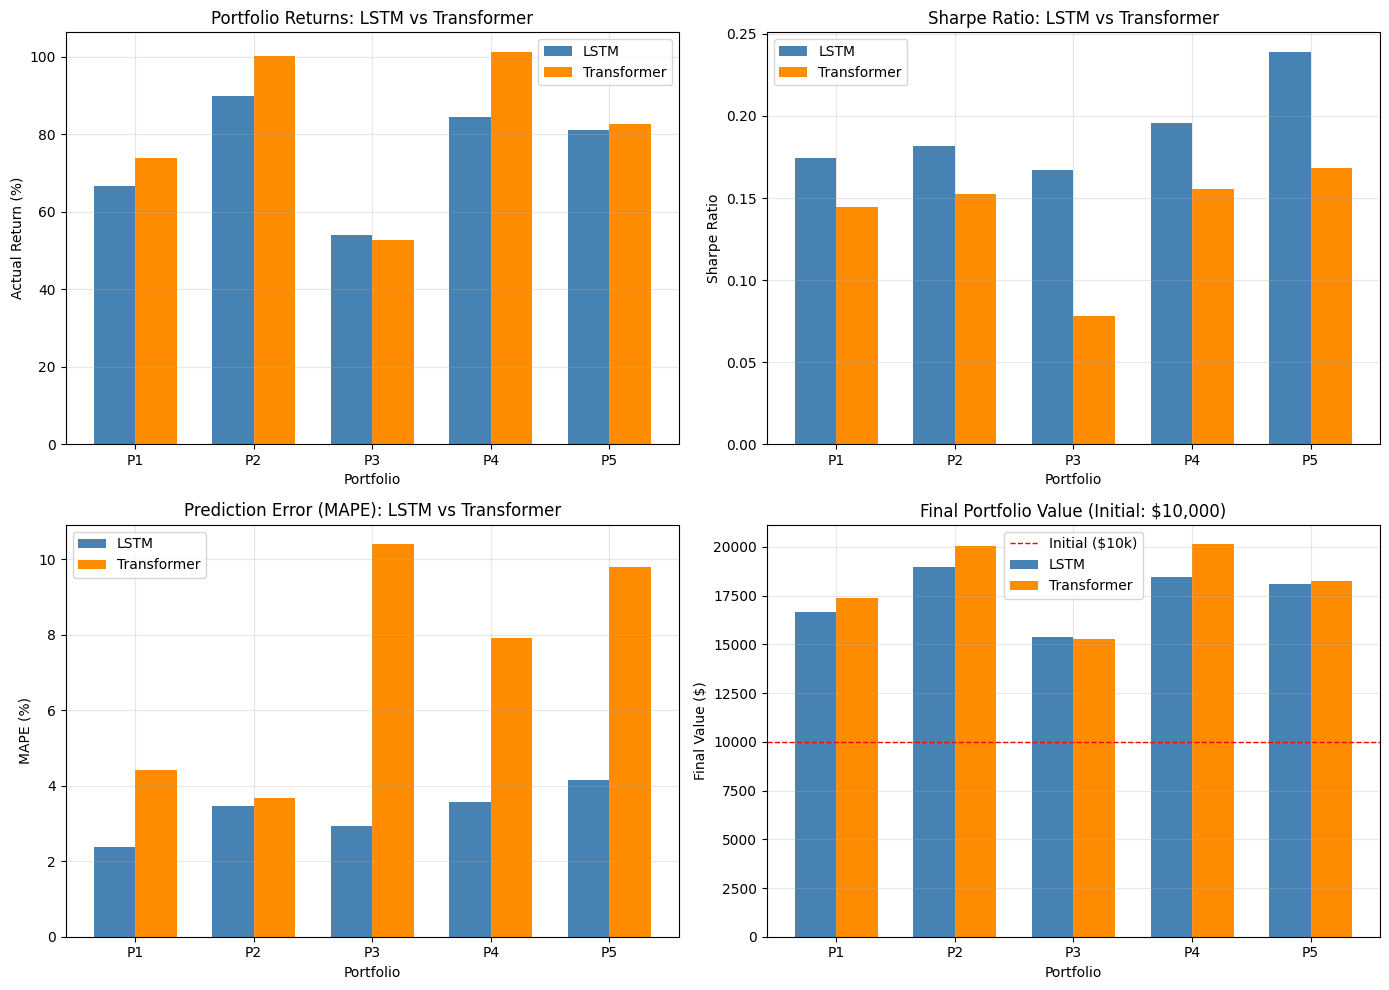


Saved: lstm_vs_transformer_comparison.png


In [34]:
# Visualization: LSTM vs Transformer Portfolio Returns
if lstm_portfolio_opts and transformer_portfolio_opts:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Portfolio Returns Comparison
    n_portfolios = len(lstm_portfolio_opts)
    x = np.arange(n_portfolios)
    width = 0.35
    
    lstm_returns = [p['actual_return']*100 for p in lstm_portfolio_opts]
    trans_returns = [p['actual_return']*100 for p in transformer_portfolio_opts]
    
    axes[0, 0].bar(x - width/2, lstm_returns, width, label='LSTM', color='steelblue')
    axes[0, 0].bar(x + width/2, trans_returns, width, label='Transformer', color='darkorange')
    axes[0, 0].set_xlabel('Portfolio')
    axes[0, 0].set_ylabel('Actual Return (%)')
    axes[0, 0].set_title('Portfolio Returns: LSTM vs Transformer')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([f'P{i+1}' for i in range(n_portfolios)])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 2. Sharpe Ratio Comparison
    lstm_sharpes = [p['sharpe_ratio'] for p in lstm_portfolio_opts]
    trans_sharpes = [p['sharpe_ratio'] for p in transformer_portfolio_opts]
    
    axes[0, 1].bar(x - width/2, lstm_sharpes, width, label='LSTM', color='steelblue')
    axes[0, 1].bar(x + width/2, trans_sharpes, width, label='Transformer', color='darkorange')
    axes[0, 1].set_xlabel('Portfolio')
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].set_title('Sharpe Ratio: LSTM vs Transformer')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([f'P{i+1}' for i in range(n_portfolios)])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. MAPE Comparison
    axes[1, 0].bar(x - width/2, lstm_mapes, width, label='LSTM', color='steelblue')
    axes[1, 0].bar(x + width/2, transformer_mapes, width, label='Transformer', color='darkorange')
    axes[1, 0].set_xlabel('Portfolio')
    axes[1, 0].set_ylabel('MAPE (%)')
    axes[1, 0].set_title('Prediction Error (MAPE): LSTM vs Transformer')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([f'P{i+1}' for i in range(n_portfolios)])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final Portfolio Value
    lstm_values = [p['final_value'] for p in lstm_portfolio_opts]
    trans_values = [p['final_value'] for p in transformer_portfolio_opts]
    
    axes[1, 1].bar(x - width/2, lstm_values, width, label='LSTM', color='steelblue')
    axes[1, 1].bar(x + width/2, trans_values, width, label='Transformer', color='darkorange')
    axes[1, 1].axhline(y=10000, color='red', linestyle='--', linewidth=1, label='Initial ($10k)')
    axes[1, 1].set_xlabel('Portfolio')
    axes[1, 1].set_ylabel('Final Value ($)')
    axes[1, 1].set_title('Final Portfolio Value (Initial: $10,000)')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([f'P{i+1}' for i in range(n_portfolios)])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lstm_vs_transformer_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: lstm_vs_transformer_comparison.png")

---

## References

1. Vaswani, A., et al. (2017). "Attention is All You Need." NeurIPS.
2. Kazemi, S.M., et al. (2019). "Time2Vec: Learning a General Representation of Time." arXiv:1907.05321.
3. Sen, J., et al. (2021). "Stock Price Prediction Using Machine Learning and LSTM-Based Deep Learning Models." Springer.

---

**NYU MSCS Deep Learning - Fall 2025**

Aranya Aryaman (aa12939) & Prashanth Kumar (pk3047)